# Self-Exciting process (Hawkes process)

For a review of self-exciting point processes and more please see https://arxiv.org/pdf/1507.02822.pdf.

Hear a Poisson point process's intensity, $\lambda(t)$, is conditionally dependent on past events.

Let the intensity be given by a constant background plus an exponential term:

$$\lambda(t) = \mu + \sum_{t_i < t}  \phi(t-t_i)$$

The average number of _daughters_ from an event is $\int_0^\infty \phi(t) \mathrm{d} t$ and is called the branching ratio. If the branching ratio is > 1 then there is non-zero probability of having infinite events spawned from a single event.

We'll let $\phi(t) = \alpha e^{-\beta t}$, where $\int_0^\infty \phi(t) \mathrm{d} t = \alpha/\beta \triangleq B$.

In [1]:
from jaxns import NestedSampler
from jaxns.prior_transforms import PriorChain, HalfLaplacePrior, UniformPrior
from jaxns import summary, resample
from jaxns import plot_cornerplot, plot_diagnostics
from jax import random, numpy as jnp, vmap
import pylab as plt

In [2]:
# Generate data

num_samples = 10

event_times = jnp.concatenate([jnp.linspace(0., 1., num_samples)**2,
                               2.+jnp.linspace(0., 1., num_samples)**2])

INFO[2022-06-01 13:28:16,153]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-06-01 13:28:16,154]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-06-01 13:28:16,154]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING[2022-06-01 13:28:16,155]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
# Build model
B = 2.0

with PriorChain() as prior_chain:
    HalfLaplacePrior('mu', 1.)
    beta = HalfLaplacePrior('beta',num_samples)
    alpha = UniformPrior('alpha', 0., beta.multiply(B,name='betaB'))

def lam_t(mu, alpha, beta, t):
    dt = t[:,None] - event_times[None,:]
    # a-a, a-b
    phi = alpha * jnp.exp(-beta * jnp.where(dt>0,dt,0)) * jnp.where(dt>0,1,0)
    lam = mu + jnp.sum(phi, axis=1)
    return lam

def log_likelihood(mu, alpha, beta):
    """
    Poisson likelihood.
    """
    lam = lam_t(mu, alpha, beta, event_times)
    Lam = mu + B * event_times.size
    return jnp.sum(jnp.log(lam)) - Lam


In [4]:
prior_chain.build()
prior_chain.test_prior(random.PRNGKey(42), 10, log_likelihood=log_likelihood)


INFO[2022-06-01 13:28:17,426]: Log-likelihood: -0.3399200439453125
INFO[2022-06-01 13:28:17,440]: Log-likelihood: -38.832820892333984
INFO[2022-06-01 13:28:17,453]: Log-likelihood: -10.252197265625
INFO[2022-06-01 13:28:17,466]: Log-likelihood: -13.325328826904297
INFO[2022-06-01 13:28:17,480]: Log-likelihood: 0.5450668334960938
INFO[2022-06-01 13:28:17,493]: Log-likelihood: -17.594247817993164
INFO[2022-06-01 13:28:17,506]: Log-likelihood: -90.94427490234375
INFO[2022-06-01 13:28:17,520]: Log-likelihood: -23.13807487487793
INFO[2022-06-01 13:28:17,533]: Log-likelihood: -48.289363861083984
INFO[2022-06-01 13:28:17,546]: Log-likelihood: -5.330493927001953


In [5]:
# Run the nested sampling
ns = NestedSampler(loglikelihood=log_likelihood,
                   prior_chain=prior_chain,
                   sampler_kwargs=dict(max_num_slices=200))

results = ns(random.PRNGKey(3452345), adaptive_evidence_patience=2)

WARNING[2022-06-01 13:28:17,550]: Increasing max_samples (100000) by 200 to evenly divide samples_per_step
WARNING[2022-06-01 13:28:17,551]: PriorChain was already built. You may be trying to re-use a PriorChain in another NestedSampler. Use the same sample NestedSampler.
/home/albert/miniconda3/envs/jaxns_py/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1882: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "asarray")


--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 2082968
# samples: 3900
# likelihood evals / sample: 534.1
--------
logZ=3.2 +- 0.12
H=4900.0
ESS=1018
--------
alpha: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
alpha: 10.9 +- 4.3 | 6.0 / 10.2 / 16.4 | 16.2 | 12.0
--------
beta: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
beta: 5.9 +- 2.3 | 3.3 / 5.5 / 8.8 | 8.7 | 6.0
--------
mu: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
mu: 3.9 +- 1.9 | 1.6 / 3.6 / 6.5 | 3.9 | 9.4
--------


WARNING[2022-06-01 13:28:32,430]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
WARNING[2022-06-01 13:28:32,983]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


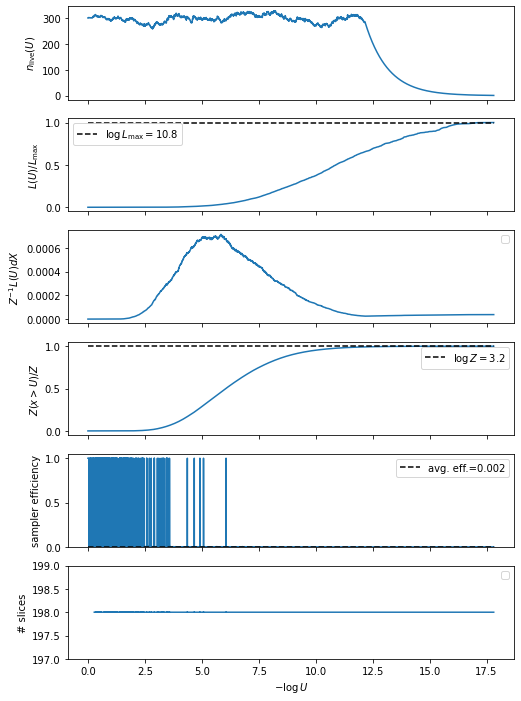

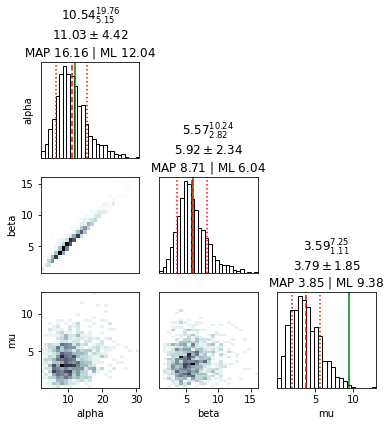

In [6]:
# Inspect results
summary(results)
plot_diagnostics(results)
plot_cornerplot(results)

In [7]:
samples = resample(random.PRNGKey(42),results.samples, results.log_dp_mean, replace=True)
pred_times = jnp.linspace(0.,4., 100)
pred_lam = vmap(lambda mu, alpha, beta: lam_t(mu, alpha, beta, pred_times))(**samples)

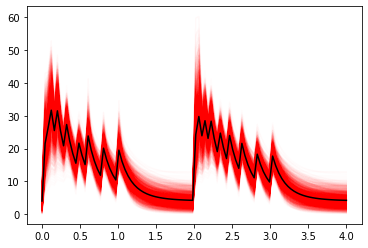

In [8]:
plt.plot(pred_times, pred_lam.T,c='red', alpha=0.01)
plt.plot(pred_times, pred_lam.mean(0),c='black')
plt.show()

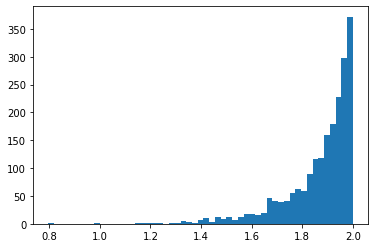

In [9]:
B = samples['alpha']/ samples['beta']
plt.hist(B, bins='auto')
plt.show()